In [ ]:
!pip install -U sentence-transformers #transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import de la dataset

In [ ]:
!pip install pandarallel  gensim==4.0.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from pandarallel import pandarallel
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


Importation de la bibliothèque

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/stack_dataset.csv")
df=df.iloc[:, :2]
df.head()

,Body,Tags
0,one project pro prepared statement con use rea...,"php,database"
1,char case random content array think sure foll...,c
2,load way dynamically function net like provide...,"net,window"
3,resolution capture image camera program strang...,"c,image"
4,new array address buffer placement portable ex...,c


# Fonctions communes

In [ ]:
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [ ]:
def vizualize(data, label=[0]):
    tsne=TSNE(n_components=3, n_jobs=-1)
    ts=tsne.fit_transform(data)
    columns=[f"v{i}" for i in range(1, ts.shape[1]+1)]
    X_df=pd.DataFrame(ts, columns=columns)
    print("dimensions apres TSNE: ", X_df.shape)
    fig=plt.figure(figsize=(10, 10))
    ax=fig.add_subplot(projection="3d")
    ax.scatter(X_df['v1'], X_df['v2'], X_df['v3'], s=30)
    ax.set_xlabel('v1')
    ax.set_ylabel('v2')
    ax.set_zlabel('v3')
    plt.show()
    print("\n", tsne.kl_divergence_)
    fig1=plt.figure(figsize=(10, 10))
    ax1=fig1.add_subplot(projection="3d")
    print(len(label), type(label))
    l=pd.DataFrame(label, columns=['cluster'])
    colors = ['y', 'g', 'r', 'k', "b", "m", "c"]
    l['c'] = l.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6]})
    ax1.scatter(X_df['v1'], X_df['v2'], X_df['v3'], s=30,color=l['c'] )
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    ax1.set_zlabel('v3')
    print("\n", tsne.kl_divergence_)
    

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, df.columns),
       # ("cat", categorical_transformer, qual),
    ]
)

In [ ]:
def colorvis(data):
  kmeans_visualizer = Pipeline([
      ("preprocessor", StandardScaler()),
      ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(3,15)))])
  kmeans_visualizer.fit(data)
  K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
  model=KMeans(n_clusters=K)
  model.fit(data)
  label=model.labels_
  vizualize(data, label)

# Tags feature extraction

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
df['Tags']=df['Tags'].apply(lambda x: x.split(','))
label=MultiLabelBinarizer()
label.fit(df['Tags'])
tags=label.transform(df['Tags'])

tags.shape

(4435, 34)

In [ ]:
len(label.classes_), label.classes_

(34, array(['algorithm', 'android', 'asp', 'c', 'cs', 'data', 'database',
        'design', 'django', 'file', 'google', 'html', 'http', 'image',
        'io', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'memory',
        'mvc', 'net', 'performance', 'php', 'python', 'ruby', 'server',
        'spring', 'sql', 'studio', 'visual', 'web', 'window'], dtype=object))

In [ ]:
tags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
dftags=pd.DataFrame(tags, columns=label.classes_)
dftags.head()

,algorithm,android,asp,c,cs,data,database,design,django,file,...,php,python,ruby,server,spring,sql,studio,visual,web,window
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dftags.shape

(4435, 34)

In [ ]:
dftags.to_csv('tag.csv', index=False)

# Bag of words et Tf-idf

## Text feature extraction

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.5, min_df=1, max_features=2500)
ctf = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=1, max_features=2500)

cv_fit = cvect.fit(df['Body'])
ctf_fit = ctf.fit(df['Body'])

cv_fit.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ability',
 'able',
 'abort',
 'absolute',
 'absolutely',
 'abstract',
 'abstraction',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessible',
 'accomplish',
 'accomplished',
 'according',
 'accordingly',
 'account',
 'accuracy',
 'accurate',
 'achieve',
 'acquire',
 'act',
 'action',
 'activate',
 'activation',
 'active',
 'activity',
 'actual',
 'actually',
 'adapter',
 'add',
 'added',
 'addition',
 'additional',
 'additionally',
 'address',
 'adjust',
 'administrator',
 'admit',
 'advance',
 'advanced',
 'advantage',
 'advice',
 'advise',
 'affect',
 'affected',
 'afraid',
 'age',
 'agent',
 'aggregate',
 'agnostic',
 'ago',
 'agree',
 'ahead',
 'aim',
 'aka',
 'ala',
 'album',
 'alert',
 'algorithm',
 'alias',
 'align',
 'alignment',
 'alike',
 'alive',
 'allocate',
 'allocation',
 'allow',
 'alpha',
 'alright',
 'alt',
 'alter',
 'alternative',
 'alternatively',
 'ambiguous',
 'anaconda',
 'analogous',
 'analysis',
 'analytics',
 'analyze',
 'anchor',
 'android',
 'angl

In [ ]:
cv_fit.vocabulary_

{'click': 357,
 'event': 745,
 'need': 1430,
 'cancel': 285,
 'double': 653,
 'connection': 448,
 'string': 2151,
 'application': 105,
 'file': 842,
 'machine': 1303,
 'change': 317,
 'server': 2013,
 'net': 1433,
 'key': 1193,
 'time': 2280,
 'scenario': 1955,
 'user': 2396,
 'read': 1770,
 'encryption': 713,
 'level': 1237,
 'approach': 109,
 'execution': 762,
 'public': 1725,
 'private': 1681,
 'achieve': 19,
 'sign': 2037,
 'encrypt': 712,
 'possible': 1632,
 'sensitive': 1997,
 'point': 1609,
 'information': 1111,
 'code': 372,
 'detect': 586,
 'unless': 2372,
 'version': 2417,
 'make': 1312,
 'know': 1201,
 'question': 1742,
 'anybody': 94,
 'write': 2485,
 'little': 1265,
 'program': 1699,
 'content': 469,
 'enterprise': 722,
 'environment': 729,
 'sure': 2198,
 'wire': 2465,
 'especially': 738,
 'interesting': 1154,
 'deployment': 573,
 'people': 1566,
 'publisher': 1727,
 'executed': 761,
 'like': 1245,
 'sound': 2093,
 'wrong': 2489,
 'client': 358,
 'hibernate': 1019,
 'test

In [ ]:
ctf_fit.vocabulary_

{'click': 357,
 'event': 745,
 'need': 1430,
 'cancel': 285,
 'double': 653,
 'connection': 448,
 'string': 2151,
 'application': 105,
 'file': 842,
 'machine': 1303,
 'change': 317,
 'server': 2013,
 'net': 1433,
 'key': 1193,
 'time': 2280,
 'scenario': 1955,
 'user': 2396,
 'read': 1770,
 'encryption': 713,
 'level': 1237,
 'approach': 109,
 'execution': 762,
 'public': 1725,
 'private': 1681,
 'achieve': 19,
 'sign': 2037,
 'encrypt': 712,
 'possible': 1632,
 'sensitive': 1997,
 'point': 1609,
 'information': 1111,
 'code': 372,
 'detect': 586,
 'unless': 2372,
 'version': 2417,
 'make': 1312,
 'know': 1201,
 'question': 1742,
 'anybody': 94,
 'write': 2485,
 'little': 1265,
 'program': 1699,
 'content': 469,
 'enterprise': 722,
 'environment': 729,
 'sure': 2198,
 'wire': 2465,
 'especially': 738,
 'interesting': 1154,
 'deployment': 573,
 'people': 1566,
 'publisher': 1727,
 'executed': 761,
 'like': 1245,
 'sound': 2093,
 'wrong': 2489,
 'client': 358,
 'hibernate': 1019,
 'test

In [ ]:
cv_transform = cvect.transform(df['Body'])  
ctf_transform = ctf.transform(df['Body'])  

In [ ]:
np.save("cv_transform.npy", cv_transform, allow_pickle=True)
np.save("ctf_transform.npy", ctf_transform, allow_pickle=True)
np.save("ctf_transform_feature_names.npy", cv_fit.get_feature_names(), allow_pickle=True)


In [ ]:
df1=pd.DataFrame(cv_transform.toarray())
df1.columns=cvect.get_feature_names()
df1.head()

,ability,able,abort,absolute,absolutely,abstract,abstraction,accept,acceptable,accepted,...,wrote,yahoo,year,yes,yesterday,yield,zero,zip,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4268, 3)


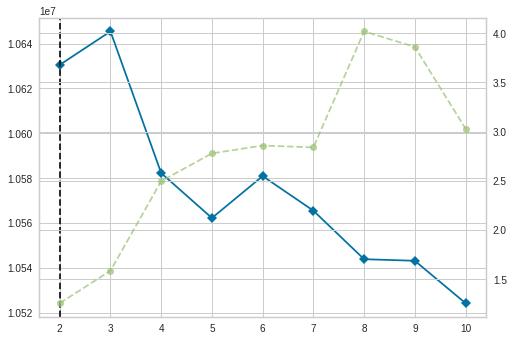

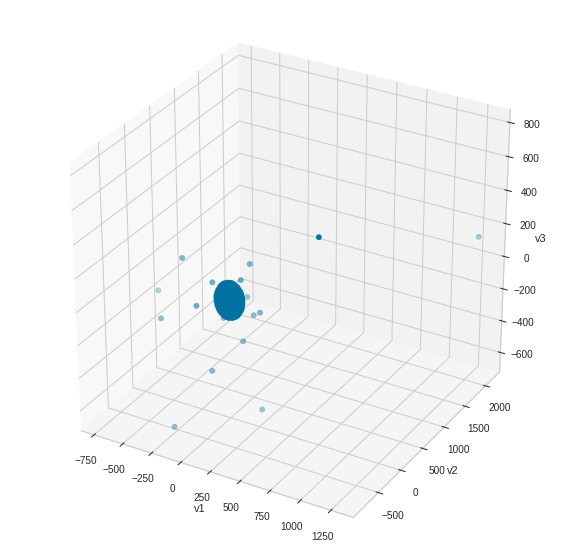


 6.6462812423706055
4268 <class 'numpy.ndarray'>

 6.6462812423706055


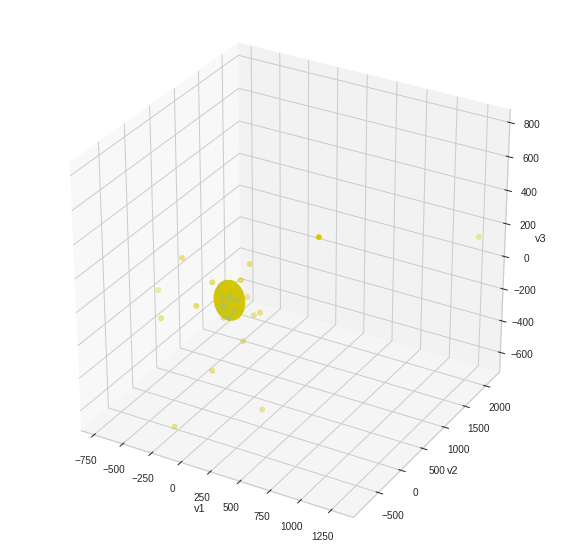

In [ ]:
colorvis(df1)

In [ ]:
df1.to_csv('cvect.csv', index=False)

In [ ]:
df2=pd.DataFrame(ctf_transform.toarray())
df2.columns=ctf.get_feature_names()
df2.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,able,abort,absolute,absolutely,abstract,abstraction,accept,acceptable,accepted,...,wrote,yahoo,year,yes,yesterday,yield,zero,zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df1.shape, df2.shape

((4268, 2500), (4268, 2500))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4268, 3)


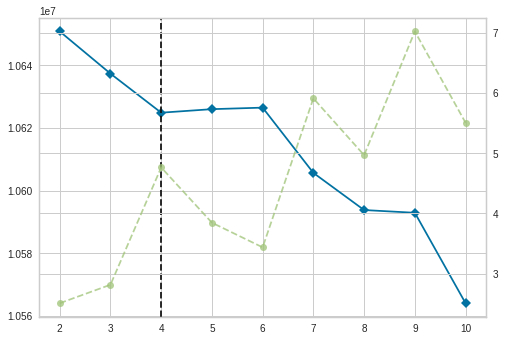

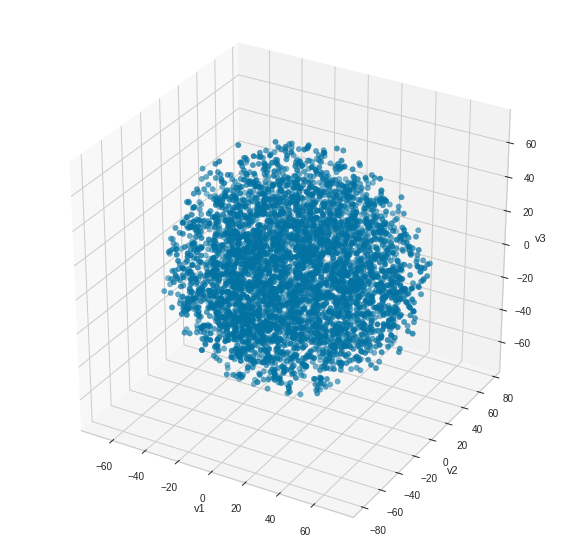


 3.062262535095215
4268 <class 'numpy.ndarray'>

 3.062262535095215


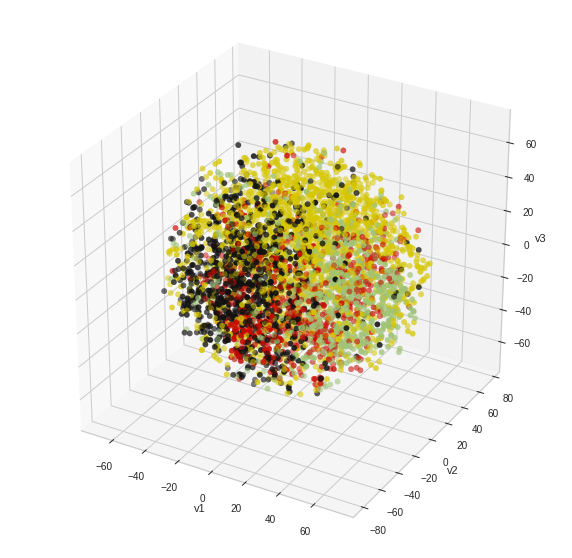

In [ ]:
colorvis(df2)

In [ ]:
df2.to_csv('ctf.csv', index=False)

# Doc2vec

In [ ]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
        
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/text_data.csv")
data=df.Body.tolist()
tagged_data = [TaggedDocument(words=word_tokenize(d), tags=[str(i)]) for i, d in enumerate(data)]

In [ ]:
tagged_data[0]

TaggedDocument(words=['click', 'event', 'done', 'need', 'cancel', 'double'], tags=['0'])

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(#size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0
                )
  
vocab=model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=1)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [ ]:
doc_data=[]
for i in range(len(tagged_data)):
  doc_data.append(model.infer_vector(tagged_data[i].words))
doc_df=pd.DataFrame(doc_data)
doc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.019134,-0.007889,0.007676,-0.027816,0.010023,-0.010717,-0.009137,0.002392,0.003788,0.004628,...,-0.001810,0.030322,-0.007474,0.008246,0.029430,-0.004082,0.045184,-0.000424,0.004723,-0.018900
1,-0.063981,-0.104218,0.041758,-0.096471,0.015515,0.025741,-0.028815,0.096863,0.027948,-0.019350,...,0.063687,0.065750,-0.010846,0.095313,0.055719,0.056937,0.089742,-0.027968,0.057919,0.008452
2,-0.048045,-0.061316,0.035655,-0.159495,0.019836,0.024180,-0.024126,0.038720,0.013660,-0.020533,...,0.015402,0.045530,-0.032715,0.091415,0.146266,0.033984,0.132457,-0.037389,0.086705,0.032783
3,-0.021914,-0.014708,-0.007920,-0.077519,0.000832,-0.008692,-0.003820,-0.000393,0.021959,-0.000896,...,0.025362,0.008688,-0.025179,0.023623,0.035825,0.029510,0.066941,0.007780,0.010991,0.001120
4,-0.015461,-0.002887,0.008705,-0.009735,0.002905,0.002052,0.006018,0.007021,-0.007932,0.002863,...,0.005608,-0.002361,0.004891,0.003114,0.012874,0.005537,0.007421,-0.015598,0.016119,-0.000742


In [ ]:
doc_df.shape

(4268, 100)

In [ ]:
#vizualize(doc_df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4268, 3)
4268 <class 'numpy.ndarray'>

 3.030768871307373


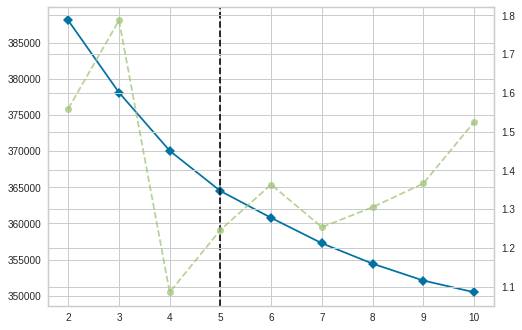

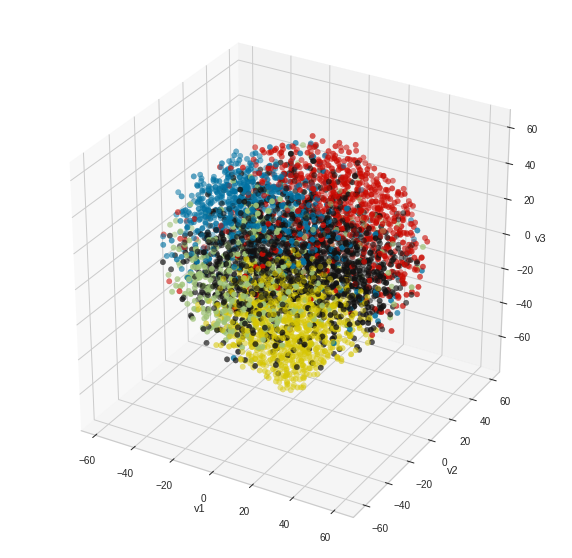

In [ ]:
colorvis(doc_df)

In [ ]:
doc_df.to_csv('doc2vec.csv', index=False)

# Sbert

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
sentences=df.Body.tolist()
embeddings = model.encode(sentences)
type(embeddings)

numpy.ndarray

In [ ]:
df_sbert=pd.DataFrame(embeddings)
df_sbert.head()


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.023766,-0.006166,0.075951,0.029492,-0.043110,0.009244,0.073653,-0.027813,0.065415,0.026349,...,0.062064,-0.006343,-0.008137,0.010188,0.023841,0.115756,0.056342,0.011597,-0.072947,-0.065070
1,-0.037815,0.027269,-0.054552,-0.031339,-0.074008,0.026008,0.059062,0.030023,-0.023214,0.010859,...,0.039001,0.083128,0.024738,0.008115,0.048526,0.077536,-0.030913,0.012034,0.019530,-0.065491
2,0.038634,-0.025317,-0.046777,0.025148,-0.066486,0.033910,-0.000132,-0.052300,-0.067114,0.047379,...,-0.055911,0.012187,0.067242,0.035780,0.063157,-0.014858,0.065285,-0.043023,0.027793,0.005009
3,-0.009476,0.068318,0.011777,-0.049361,-0.086532,0.064935,0.020729,0.066908,-0.047439,0.037339,...,-0.042568,-0.015787,-0.014768,0.022089,0.001135,-0.051574,0.060479,-0.083959,-0.034596,0.091289
4,0.069085,0.000022,-0.088062,-0.072774,-0.028215,-0.044291,-0.059796,-0.014299,0.006775,0.003531,...,0.042649,-0.022298,-0.027504,0.057372,0.044032,0.104384,-0.005932,0.113859,-0.002459,-0.091971


In [ ]:
df_sbert.shape

(4268, 384)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4268, 3)
1 <class 'list'>

 2.121551513671875


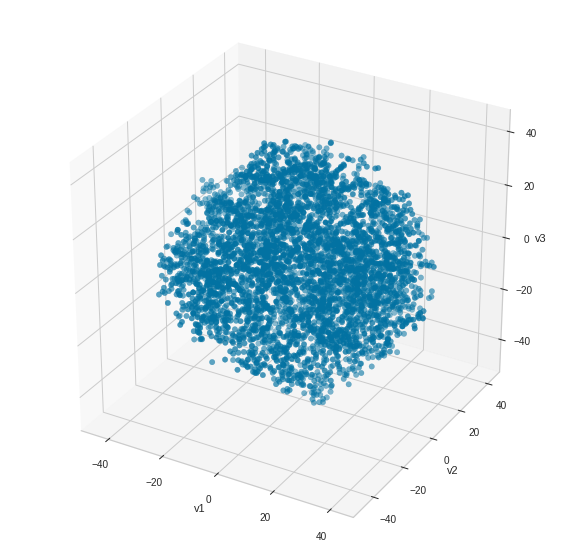

In [ ]:
vizualize(df_sbert)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4268, 3)
4268 <class 'numpy.ndarray'>

 2.137166738510132


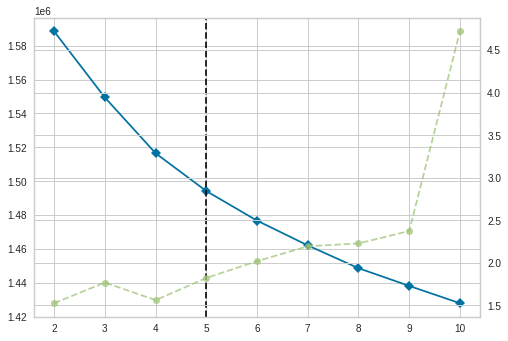

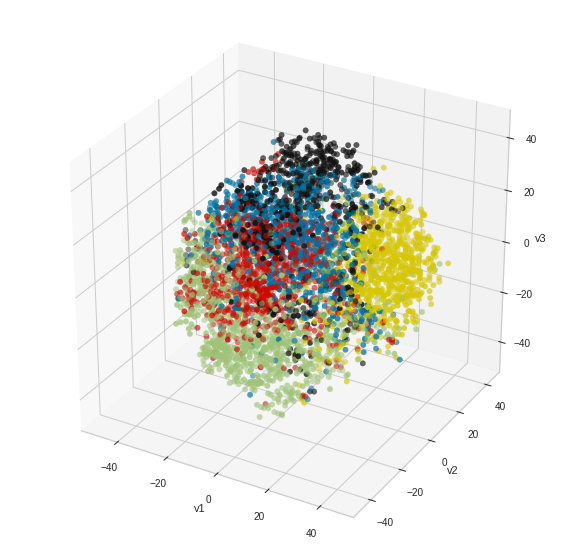

In [ ]:
colorvis(df_sbert)

In [ ]:
df_sbert.to_csv("sbert.csv", index=False)

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num TPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.2
2.9.2
Num TPUs Available:  0
True


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = df['Body'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
df5=pd.DataFrame(features_USE, columns=[f'v{i}' for i in range(1, features_USE.shape[1]+1)])
df5.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512
0,-0.077122,-0.080970,0.005456,0.035707,0.064674,-0.005285,0.005813,-0.075428,0.017741,0.050165,...,0.068385,-0.040829,0.046174,-0.007482,0.065247,-0.002520,-0.041358,-0.017469,-0.055071,0.020884
1,0.005778,0.036680,-0.058091,-0.039633,-0.026311,0.056365,-0.052766,-0.026739,0.044230,0.068073,...,-0.071424,-0.073890,-0.061559,0.019565,-0.063289,-0.021574,-0.007917,0.069691,-0.028093,-0.001312
2,0.016877,-0.072908,-0.034443,-0.048132,-0.050691,0.056656,0.035941,-0.030114,-0.029109,0.072111,...,-0.034533,-0.073088,0.009719,-0.043922,-0.007792,0.061647,0.020541,0.073220,-0.028453,-0.017719
3,-0.002389,-0.086363,0.029645,0.004709,0.003480,0.080840,0.068007,-0.058380,-0.036986,0.036299,...,-0.027629,-0.072780,-0.047313,-0.044506,0.030158,0.017988,0.024105,0.022766,0.040751,-0.033656
4,-0.053490,-0.054620,-0.044233,0.034836,0.072692,0.016400,-0.042965,-0.009806,0.044816,-0.001771,...,0.044362,-0.081973,0.037593,0.049752,0.018414,-0.002643,-0.070140,-0.015802,0.044645,-0.059623


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


dimensions apres TSNE:  (4260, 3)


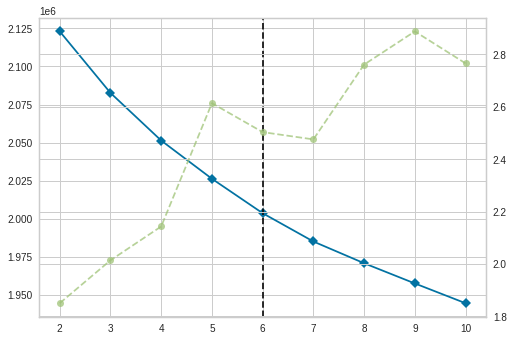

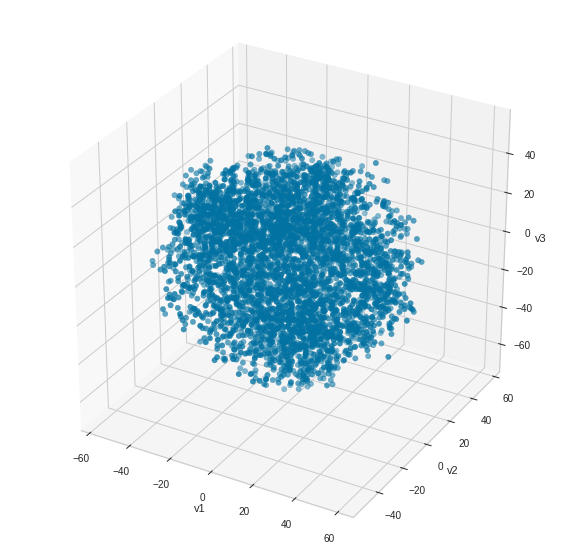


 2.403256416320801
4260 <class 'numpy.ndarray'>

 2.403256416320801


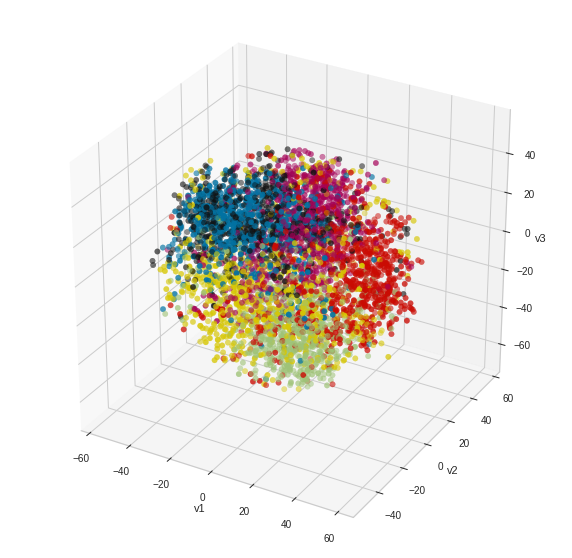

In [ ]:
colorvis(df5)

In [ ]:
df5.to_csv('use.csv')

# Chargement des librairies et données

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/text_data.csv")
dfcv=pd.read_csv('/content/drive/MyDrive/cvect.csv')
dftf=pd.read_csv('/content/drive/MyDrive/ctf.csv')
dfwtovec=pd.read_csv('/content/drive/MyDrive/doc2vec.csv')
dfbert=pd.read_csv('/content/drive/MyDrive/sbert.csv')
dfuse=pd.read_csv('/content/drive/MyDrive/use.csv')
dftag=pd.read_csv('/content/drive/MyDrive/tag.csv')
df.head()

,Body,Tags
0,click event done need cancel double,"javascript,jquery"
1,connection string application file machine cha...,net
2,hibernate test spring way bean row table find ...,"java,spring,data"
3,property car object implement following scenar...,javascript
4,convert server,"sql,server"


In [ ]:
liste=[df, dfcv, dftf,dfwtovec,dfbert,dfuse,dftag]

In [ ]:
dfcv.head()

,ability,able,absolute,absolutely,abstract,accent,accept,acceptable,accepted,access,...,yahoo,year,yellow,yes,yesterday,yield,zero,zip,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for dfi in liste:
  print(dfi.shape)

(4268, 2)
(4435, 2500)
(4435, 2500)
(4268, 100)
(4268, 384)
(4430, 513)
(4435, 34)


In [ ]:
ctf_transform = np.load("/content/drive/MyDrive/ctf_transform.npy", allow_pickle=True).item()
ctf_feature_names = np.load("/content/drive/MyDrive/ctf_transform_feature_names.npy" , allow_pickle=True )
cv_transform= np.load("/content/drive/MyDrive/cv_transform.npy" , allow_pickle=True, ).item() 

In [ ]:
dftag.head()

,algorithm,android,asp,c,cs,data,database,design,django,file,...,php,python,ruby,server,spring,sql,studio,visual,web,window
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Approche Non supervisé:LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Gridsearchcv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

lda = LatentDirichletAllocation(n_jobs=-1, random_state=42)

params = {'n_components' : [8, 15, 20]}

grid_lda = GridSearchCV(lda,
                              param_grid=params,
                              verbose=3,
                              cv=2)

grid_lda.fit(dftf.values)

print(grid_lda.best_estimator_, grid_lda.best_score_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END ..............n_components=8;, score=-100623.912 total time=  13.0s
[CV 2/2] END ..............n_components=8;, score=-101280.709 total time=   6.6s
[CV 1/2] END .............n_components=15;, score=-107906.824 total time=   6.5s
[CV 2/2] END .............n_components=15;, score=-105269.745 total time=   5.7s
[CV 1/2] END .............n_components=20;, score=-110964.968 total time=   5.6s
[CV 2/2] END .............n_components=20;, score=-112550.879 total time=   5.9s
LatentDirichletAllocation(n_components=8, n_jobs=-1, random_state=42) -100952.3106729339


In [ ]:

n_topic=8
lda=LatentDirichletAllocation(n_jobs=-1, n_components=n_topic, learning_method='online', learning_offset=50, random_state=0)
lda =lda.fit(dftf.values)
lda.components_

array([[0.12508318, 0.12507191, 0.12508429, ..., 0.12506786, 0.12505976,
        0.12505213],
       [0.125066  , 0.12510332, 0.12507293, ..., 0.12506399, 0.12508134,
        0.12507111],
       [0.12508356, 0.12507056, 0.12505788, ..., 0.12506671, 0.12507269,
        0.12507329],
       ...,
       [0.12516846, 0.12527672, 0.12509056, ..., 0.12505777, 0.12515679,
        0.12506476],
       [0.12508266, 0.12511673, 0.12507747, ..., 0.12505478, 0.12506387,
        0.12505896],
       [0.12509965, 0.12517126, 0.12506894, ..., 0.12506693, 0.12513846,
        0.12507465]])

In [ ]:
dftf.shape

(4435, 2500)

In [ ]:
# Nous n'allons afficher que les 10 mots les plus importants par Sujet
n_tag=10
for x, topic in enumerate(lda.components_):
        print("\n")
        print(f"Sujet {x}:")
        print(" ".join([ctf_feature_names[i] for i in topic.argsort()[::-1][:n_tag]]))



Sujet 0:
flag explain server difference perform dom valid tell evaluate current


Sujet 1:
iso way sleep pass net best date time view asp


Sujet 2:
explanation big notation pointer use little local difference degree anybody


Sujet 3:
like use way want code work need file know new


Sujet 4:
use difference python better reading people recently know specifically traditional


Sujet 5:
busy process causing throughput drive device disk use file need


Sujet 6:
benefit strong deal way recall type cause array scatter template


Sujet 7:
use net make way bar want problem method text button


In [ ]:
lda.components_.shape

(8, 2500)

## Evaluation  du score du model

In [ ]:
#calculating and displaying the coherence score
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

data = [d.split() for d in df['Body'].values]
dictionary = Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]



# Build LDA model
lda = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=8, 
                            random_state=42) 
from gensim.models import CoherenceModel

# Compute Coherence Score
c_model = CoherenceModel(model=lda, texts=data, corpus=corpus, coherence='c_v')
coherence_lda = c_model.get_coherence()


print("\nCoherence score : ", coherence_lda)


Coherence score :  0.4714282802426757


# Fonctions communes

In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 2.2 MB/s 


In [ ]:
# ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# Multi Label 
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
import skmultilearn

Metrics

In [ ]:
from sklearn.metrics import hamming_loss, jaccard_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score, recall_score, make_scorer
from sklearn.metrics import multilabel_confusion_matrix , confusion_matrix, f1_score

In [ ]:
def evaluate(y_test, y_pred):
  acc=accuracy_score(y_test,y_pred.toarray())
  incorrect=hamming_loss(y_test,y_pred.toarray())
  
  print('Precision du model ===============>', acc, '\n')
  print("Taux de prediction incorrect =====>", incorrect,'\n')
  jacc=jaccard_score(y_test, y_pred.toarray(), average="macro")
  print("Le jaccard_score =================>", jacc)

In [ ]:
def evaluate_baseline(y_pred, y_test):
  acc=accuracy_score(y_test,y_pred)
  incorrect=hamming_loss(y_test,y_pred)
  print('Precision du model ===============>', acc, '\n')
  print("Taux de prediction incorrect =====>", incorrect, '\n')
  jacc=jaccard_score(y_test, y_pred, average="macro")
  print("Le jaccard_score =================>", jacc)

In [ ]:
from sklearn.decomposition import PCA

def apc(data):
  pca=PCA(n_components=0.8)
  X=pca.fit_transform(data)
  print(X.shape)
  columns=[f'v{i}' for i in range(1, X.shape[1]+1, 1)]
  X=pd.DataFrame(X, columns=columns)
  
  return X

In [ ]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers import Embedding 
from keras.layers import Input
from keras.preprocessing.text import Tokenizer

def deepmodel(X_train_i, y_train_i, X_test_i, y_test_i, input ):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(df.Body)
  vocab_size = len(tokenizer.word_index) + 1
  deep_inputs = Input(shape=(input,))
  embedding_layer = Embedding(vocab_size, 100,)(deep_inputs)
  LSTM_Layer_1 = LSTM(128)(embedding_layer)
  dense_layer_1 = Dense(34, activation='sigmoid')(LSTM_Layer_1)
  model = Model(inputs=deep_inputs, outputs=dense_layer_1)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  history = model.fit(X_train_i, y_train_i,
                    epochs=5,
                    validation_split=0.1,
                    )
  score = model.evaluate(X_test_i, y_test_i, verbose=1)
  print("Perte:", score[0])
  print("Precision :", score[1])
  
  return model

In [ ]:
dftag.dtypes.value_counts()

int64    34
dtype: int64

# Classification supervisée sans APC

## Tf-idf

In [ ]:
X_train, X_test, y_train,  y_test=train_test_split(dftf, dftag, test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape

((3104, 2500), (1331, 2500), (3104, 34))

### 0. Dummyclassifier

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_model = MultiOutputClassifier(dummy)
dummy_model.fit(X_train, y_train)
y_pred6 = dummy_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
evaluate_baseline(y_test, y_pred6)

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.05113360144959562 

Le jaccard_score =================> 0.0


### 1. Binary relevance

In [ ]:
bin_model=BinaryRelevance(MultinomialNB())

In [ ]:
bin_model.fit(X_train,y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

Prediction

In [ ]:
y_pred=bin_model.predict(X_test)
y_pred.toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MultinomialNB was fitt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Evaluation du model

In [ ]:
evaluate(y_test, y_pred)

Precision du model ===============> 0.03606311044327573 

Taux de prediction incorrect =====> 0.04974145931851328 

Le jaccard_score =================> 0.008539283643353044


### 2. Classifier chain
Conservation de la correlation entre les tags

In [ ]:
chain_model=ClassifierChain(MultinomialNB())
chain_model.fit(X_train, y_train)

ClassifierChain(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred2=chain_model.predict(X_test)
y_pred2.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
evaluate(y_test, y_pred2)

Precision du model ===============> 0.05559729526671676 

Taux de prediction incorrect =====> 0.04923321695319751 

Le jaccard_score =================> 0.016115535780993475


### 3. Par LabelPowerset


In [ ]:
power_model=LabelPowerset(MultinomialNB())
power_model.fit(X_train, y_train)

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred3=chain_model.predict(X_test)
y_pred3.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
evaluate(y_test, y_pred3)

Precision du model ===============> 0.05559729526671676 

Taux de prediction incorrect =====> 0.04923321695319751 

Le jaccard_score =================> 0.016115535780993475


### 4. KNeiborsClassifier

In [ ]:
from sklearn.model_selection import KFold

k_neighbors = KNeighborsClassifier()
k_neighbors = MultiOutputClassifier(k_neighbors)


n_jobs=[-1]

hyperparameters = dict(estimator__n_neighbors = np.arange(2, 10, 4),
                       n_jobs = n_jobs
                      )

grid = GridSearchCV(k_neighbors, hyperparameters, cv=4, scoring='accuracy')
grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=  42.3s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=  24.5s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=  23.4s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=  23.9s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=  25.8s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=  23.7s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=  22.5s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=  26.9s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=  30.5s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=  23.0s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=  23.5s
[CV] END ...............estimator__n_neighbors=1

GridSearchCV(cv=KFold(n_splits=4, random_state=123, shuffle=True),
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38]),
                         'n_jobs': [-1]},
             scoring='accuracy', verbose=2)

In [ ]:
grid.best_params_

{'estimator__n_neighbors': 6, 'n_jobs': -1}

In [ ]:
y_pred4=grid.predict(X_test)
evaluate_baseline(y_test, y_pred4)

Precision du model ===============> 0.11720510894064613 

Taux de prediction incorrect =====> 0.04503469306580634 

Le jaccard_score =================> 0.13090234173599552


### 5. SVC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
classifier = SVC()
classifier = MultiOutputClassifier(classifier)
GridSearchCV(classifier, param_grid={}, scoring='accuracy').get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__estimator__C', 'estimator__estimator__break_ties', 'estimator__estimator__cache_size', 'estimator__estimator__class_weight', 'estimator__estimator__coef0', 'estimator__estimator__decision_function_shape', 'estimator__estimator__degree', 'estimator__estimator__gamma', 'estimator__estimator__kernel', 'estimator__estimator__max_iter', 'estimator__estimator__probability', 'estimator__estimator__random_state', 'estimator__estimator__shrinking', 'estimator__estimator__tol', 'estimator__estimator__verbose', 'estimator__estimator', 'estimator__n_jobs', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:

GridSearchCV(classifier, param_grid={}, scoring='accuracy').get_params().keys()
hyperparameters = dict(estimator__C = [1, 10],
                       n_jobs = [-1],
                       estimator__kernel =['rbf', 'poly', 'sigmoid']
                      )

grid2=GridSearchCV(estimator=classifier,param_grid=hyperparameters, cv=4,  scoring='accuracy')
grid2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MultiOutputClassifier(estimator=SVC()),
             param_grid={'estimator__C': [1, 10], 'n_jobs': [-1]},
             scoring='accuracy')

In [ ]:
grid2.best_params_

{'estimator__C': 10, 'n_jobs': -1}

In [ ]:
model5=MultiOutputClassifier(estimator=SVC(C=10))
model5.fit(X_train, y_train)

MultiOutputClassifier(estimator=SVC(C=10))

In [ ]:

evaluate_baseline(model5.predict(X_test), y_test)

Precision du model ===============> 0.18106686701728025 

Taux de prediction incorrect =====> 0.040394219295531886 

Le jaccard_score =================> 0.17542094877203618


### 6. Logistic Regression

In [ ]:
l_model=MultiOutputClassifier(LogisticRegression())

In [ ]:
l_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [ ]:
evaluate_baseline(y_test, l_model.predict(X_test))

Precision du model ===============> 0.09241172051089407 

Taux de prediction incorrect =====> 0.045697617890131256 

Le jaccard_score =================> 0.052979612579442385


In [ ]:
accuracy_score( l_model.predict(X_test), y_test)

0.09241172051089407

### DeepLearning

In [ ]:
deepmodel(X_train, y_train, X_test, y_test, 2500)

Epoch 1/5
88/88 [==============================] - 19s 133ms/step - loss: 0.2573 - acc: 0.2041 - val_loss: 0.1878 - val_acc: 0.2733
Epoch 2/5
88/88 [==============================] - 10s 113ms/step - loss: 0.1892 - acc: 0.2714 - val_loss: 0.1880 - val_acc: 0.2733
Epoch 3/5
88/88 [==============================] - 10s 115ms/step - loss: 0.1893 - acc: 0.2714 - val_loss: 0.1880 - val_acc: 0.2733
Epoch 4/5
88/88 [==============================] - 10s 116ms/step - loss: 0.1894 - acc: 0.2714 - val_loss: 0.1881 - val_acc: 0.2733
Epoch 5/5
42/42 [==============================] - 2s 45ms/step - loss: 0.1850 - acc: 0.2502
Perte: 0.1850079745054245
Precision : 0.25018781423568726


## doc2vec

In [ ]:
X_train, X_test, y_train,  y_test=train_test_split(dfwtovec[:4000], dftag[:4000], test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape

((2800, 100), (1200, 100), (2800, 34))

### 0. Dummyclassifier

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_model = MultiOutputClassifier(dummy)
dummy_model.fit(X_train, y_train)
y_pred6 = dummy_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
evaluate_baseline(y_test, y_pred6)

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.05198529411764706 

Le jaccard_score =================> 0.0


### 1. RandomForestClassifier

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
forest = RandomForestClassifier(random_state=1)
forest_model = MultiOutputClassifier(forest, n_jobs=2)


In [ ]:
forest_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=2)

Prediction

In [ ]:
y_pred=forest_model.predict(X_test)

Evaluation du model

In [ ]:
evaluate_baseline(y_test, y_pred) 

Precision du model ===============> 0.0025 

Taux de prediction incorrect =====> 0.052303921568627454 

Le jaccard_score =================> 0.0005475594493116395


### 2. Logistic Regressor
Conservation de la correlation entre les tags

In [ ]:
l_model=MultiOutputClassifier(LogisticRegression())

In [ ]:
l_model.fit(X_train, y_train)
y_hat=l_model.predict(X_test)
y_hat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
evaluate_baseline(y_test, y_hat)

Precision du model ===============> 0.0016666666666666668 

Taux de prediction incorrect =====> 0.05213235294117647 

Le jaccard_score =================> 0.0008103343020633855


### 3. KNeiborsClassifier

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
k_neighbors = KNeighborsClassifier()
k_neighbors = MultiOutputClassifier(k_neighbors)

estimator__n_neighbors = np.arange(2, 40, 4)

n_jobs=[-1]

hyperparameters = {"estimator__n_neighbors": estimator__n_neighbors,
                      'n_jobs': n_jobs,
                      }

grid = GridSearchCV(k_neighbors, hyperparameters, cv=KFold(4,shuffle=True, random_state=123), scoring='accuracy', verbose=2)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   3.1s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   1.8s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   1.7s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   1.8s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   1.9s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   1.9s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   1.9s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   1.8s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   1.9s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   2.0s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   1.9s
[CV] END ...............estimator__n_neighbors=1

GridSearchCV(cv=KFold(n_splits=4, random_state=123, shuffle=True),
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38]),
                         'n_jobs': [-1]},
             scoring='accuracy', verbose=2)

In [ ]:
grid.best_params_

{'estimator__n_neighbors': 2, 'n_jobs': -1}

In [ ]:
y_pred4=grid.best_estimator_.predict(X_test)
evaluate_baseline(y_test, y_pred4)

Precision du model ===============> 0.008333333333333333 

Taux de prediction incorrect =====> 0.055098039215686276 

Le jaccard_score =================> 0.003924532431870867


### 4. SVC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

classifier = SVC()
classifier = MultiOutputClassifier(classifier)
GridSearchCV(classifier, param_grid={}, scoring='accuracy').get_params().keys()
param_grid = {'estimator__C': [0.1,1, 10, 100], 
              'estimator__gamma': [1,0.1,0.01,0.001],
              'estimator__kernel': ['rbf', 'poly', 'sigmoid']
              }

grid2=GridSearchCV(classifier, param_grid=param_grid, cv=4, scoring='accuracy')
grid2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MultiOutputClassifier(estimator=SVC()),
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': [1, 0.1, 0.01, 0.001],
                         'estimator__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [ ]:
grid2.best_params_

{'estimator__C': 100, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}

In [ ]:
y_pred_svc=grid2.best_estimator_.predict(X_test)
evaluate_baseline(y_pred_svc, y_test)

Precision du model ===============> 0.02666666666666667 

Taux de prediction incorrect =====> 0.059730392156862745 

Le jaccard_score =================> 0.010316649143910343


### Deep learning

In [ ]:
deepmodel(X_train, y_train,X_test, y_test, 100)

Epoch 1/5
79/79 [==============================] - 3s 16ms/step - loss: 0.2561 - acc: 0.1913 - val_loss: 0.1881 - val_acc: 0.2643
Epoch 2/5
79/79 [==============================] - 1s 10ms/step - loss: 0.1861 - acc: 0.2615 - val_loss: 0.1891 - val_acc: 0.2643
Epoch 3/5
79/79 [==============================] - 1s 10ms/step - loss: 0.1863 - acc: 0.2615 - val_loss: 0.1890 - val_acc: 0.2643
Epoch 4/5
79/79 [==============================] - 1s 10ms/step - loss: 0.1862 - acc: 0.2615 - val_loss: 0.1894 - val_acc: 0.2643
Epoch 5/5
38/38 [==============================] - 0s 5ms/step - loss: 0.1876 - acc: 0.2700
Perte: 0.1875803917646408
Precision : 0.27000001072883606


## SBert

In [ ]:
X_train, X_test, y_train,  y_test=train_test_split(dfbert[:4000], dftag[:4000], test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape

((2800, 384), (1200, 384), (2800, 34))

### 0. Dummyclassifier

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_model = MultiOutputClassifier(dummy)
dummy_model.fit(X_train, y_train)
y_pred6 = dummy_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
evaluate_baseline(y_test, y_pred6)

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.05198529411764706 

Le jaccard_score =================> 0.0


### 1. KNeiborsClassifier

In [ ]:
from sklearn.model_selection import KFold

k_neighbors = KNeighborsClassifier()
k_neighbors = MultiOutputClassifier(k_neighbors)

estimator__n_neighbors = np.arange(2, 40, 4)

n_jobs=[-1]

hyperparameters = dict(estimator__n_neighbors = estimator__n_neighbors,
                       n_jobs = n_jobs
                      )

grid = GridSearchCV(k_neighbors, hyperparameters, cv=KFold(4,shuffle=True, random_state=123), scoring='accuracy', verbose=2)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   4.4s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   3.4s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   3.4s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   3.4s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   3.6s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   3.6s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   3.6s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   3.6s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   3.5s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   3.7s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   3.6s
[CV] END ...............estimator__n_neighbors=1

GridSearchCV(cv=KFold(n_splits=4, random_state=123, shuffle=True),
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38]),
                         'n_jobs': [-1]},
             scoring='accuracy', verbose=2)

In [ ]:
y_pred4=grid.predict(X_test)
evaluate_baseline(y_test, y_pred4)

Precision du model ===============> 0.009166666666666667 

Taux de prediction incorrect =====> 0.053357843137254904 

Le jaccard_score =================> 0.0024371300356699948


### 2. SVC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

classifier = SVC()
classifier = MultiOutputClassifier(classifier)
GridSearchCV(classifier, param_grid={}, scoring='accuracy').get_params().keys()
param_grid = {'estimator__C': [0.1,1, 10, 100], 
              'estimator__gamma': [1,0.1,0.01,0.001],
              'estimator__kernel': ['rbf', 'poly', 'sigmoid']
              }

grid2=GridSearchCV(classifier, param_grid=param_grid, cv=4, scoring='accuracy')
grid2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MultiOutputClassifier(estimator=SVC()),
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': [1, 0.1, 0.01, 0.001],
                         'estimator__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [ ]:
grid2.best_estimator_.get_params()

{'estimator__C': 100,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 0.1,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(C=100, gamma=0.1),
 'n_jobs': None}

In [ ]:
y_pred_svc=grid2.predict(X_test)
evaluate_baseline(y_pred_svc, y_test)

Precision du model ===============> 0.013333333333333334 

Taux de prediction incorrect =====> 0.060784313725490195 

Le jaccard_score =================> 0.008622831731649424


### 3. RandomForestClassifier

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
forest = RandomForestClassifier(random_state=1)
forest_model = MultiOutputClassifier(forest, n_jobs=2)

In [ ]:
forest_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=2)

Prediction

In [ ]:
y_pred=forest_model.predict(X_test)

Evaluation du model

In [ ]:
evaluate_baseline(y_test, y_pred) 

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.052034313725490194 

Le jaccard_score =================> 0.0


### DeepLearning model

In [ ]:
deepmodel(X_train, y_train, X_test, y_test, 384)

Epoch 1/5
79/79 [==============================] - 4s 29ms/step - loss: 0.2534 - acc: 0.2167 - val_loss: 0.1885 - val_acc: 0.2643
Epoch 2/5
79/79 [==============================] - 2s 23ms/step - loss: 0.1861 - acc: 0.2615 - val_loss: 0.1889 - val_acc: 0.2643
Epoch 3/5
79/79 [==============================] - 2s 23ms/step - loss: 0.1861 - acc: 0.2615 - val_loss: 0.1889 - val_acc: 0.2643
Epoch 4/5
79/79 [==============================] - 2s 23ms/step - loss: 0.1864 - acc: 0.2615 - val_loss: 0.1888 - val_acc: 0.2643
Epoch 5/5
38/38 [==============================] - 0s 9ms/step - loss: 0.1876 - acc: 0.2700
Perte: 0.18756859004497528
Precision : 0.27000001072883606


## Use

In [ ]:
dfuse.shape, dftag.shape

((4430, 513), (4435, 34))

In [ ]:
X_train, X_test, y_train,  y_test=train_test_split(dfuse, dftag.iloc[:dfuse.shape[0], :], test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape

((3101, 513), (1329, 513), (3101, 34))

### 0. Dummyclassifier

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_model = MultiOutputClassifier(dummy)
dummy_model.fit(X_train, y_train)
y_pred6 = dummy_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
evaluate_baseline(y_test, y_pred6)

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.05152038241933342 

Le jaccard_score =================> 0.0


### 1. KNeiborsClassifier

In [ ]:
from sklearn.model_selection import KFold

k_neighbors = KNeighborsClassifier()
k_neighbors = MultiOutputClassifier(k_neighbors)

estimator__n_neighbors = np.arange(2, 40, 4)

n_jobs=[-1]

hyperparameters = dict(estimator__n_neighbors = estimator__n_neighbors,
                       n_jobs = n_jobs
                      )

grid = GridSearchCV(k_neighbors, hyperparameters, cv=KFold(4,shuffle=True, random_state=123), scoring='accuracy', verbose=2)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   4.9s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   4.8s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   4.8s
[CV] END ................estimator__n_neighbors=2, n_jobs=-1; total time=   4.7s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   5.1s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   5.0s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   5.0s
[CV] END ................estimator__n_neighbors=6, n_jobs=-1; total time=   5.2s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   4.9s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   5.3s
[CV] END ...............estimator__n_neighbors=10, n_jobs=-1; total time=   5.0s
[CV] END ...............estimator__n_neighbors=1

GridSearchCV(cv=KFold(n_splits=4, random_state=123, shuffle=True),
             estimator=MultiOutputClassifier(estimator=KNeighborsClassifier()),
             param_grid={'estimator__n_neighbors': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38]),
                         'n_jobs': [-1]},
             scoring='accuracy', verbose=2)

In [ ]:
y_pred4=grid.predict(X_test)
evaluate_baseline(y_test, y_pred4)

Precision du model ===============> 0.014296463506395787 

Taux de prediction incorrect =====> 0.0548842561855442 

Le jaccard_score =================> 0.005863803152592754


### 2. SVC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

classifier = SVC()
classifier = MultiOutputClassifier(classifier)
GridSearchCV(classifier, param_grid={}, scoring='accuracy').get_params().keys()
param_grid = {'estimator__C': [0.1,1, 10, 100], 
              #'estimator__gamma': [1,0.1,0.01,0.001],
              #'estimator__kernel': ['rbf', 'poly', 'sigmoid']
              }

grid2=GridSearchCV(classifier, param_grid=param_grid, cv=4, scoring='accuracy')
grid2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MultiOutputClassifier(estimator=SVC()),
             param_grid={'estimator__C': [0.1, 1, 10, 100]},
             scoring='accuracy')

In [ ]:
grid2.best_estimator_.get_params()

{'estimator__C': 0.1,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(C=0.1),
 'n_jobs': None}

In [ ]:
y_pred_svc=grid2.predict(X_test)
evaluate_baseline(y_pred_svc, y_test)

Precision du model ===============> 0.0 

Taux de prediction incorrect =====> 0.05152038241933342 

Le jaccard_score =================> 0.0


### 3. RandomForestClassifier

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
forest = RandomForestClassifier(random_state=1)
forest_model = MultiOutputClassifier(forest, n_jobs=2)

In [ ]:
forest_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=2)

Prediction

In [ ]:
y_pred=forest_model.predict(X_test)

Evaluation du model

In [ ]:
evaluate_baseline(y_test, y_pred) 

Precision du model ===============> 0.10082768999247554 

Taux de prediction incorrect =====> 0.04536803434692161 

Le jaccard_score =================> 0.06270863579099059


### Deep Learning

In [ ]:
deepmodel(X_train, y_train, X_test, y_test, 513)

Epoch 1/5
88/88 [==============================] - 5s 36ms/step - loss: 0.2484 - acc: 0.2516 - val_loss: 0.1888 - val_acc: 0.2733
Epoch 2/5
88/88 [==============================] - 3s 30ms/step - loss: 0.1886 - acc: 0.2688 - val_loss: 0.1891 - val_acc: 0.2733
Epoch 3/5
88/88 [==============================] - 3s 30ms/step - loss: 0.1887 - acc: 0.2688 - val_loss: 0.1892 - val_acc: 0.2733
Epoch 4/5
88/88 [==============================] - 3s 30ms/step - loss: 0.1888 - acc: 0.2688 - val_loss: 0.1893 - val_acc: 0.2733
Epoch 5/5
42/42 [==============================] - 1s 12ms/step - loss: 0.1857 - acc: 0.2566
Perte: 0.18569733202457428
Precision : 0.25658389925956726


## Nous gardons le model de deep learning sur les donnés tfidf il est rapide à transformer les documents en vecteurs plus que tous les autres models mais aussi et ce model obtient presque la meme précision sur sa sortie que sur tous les autres(sbert, use, )

# Classification supervisée avec APC sur le model chosis

## Tf-idf

In [ ]:
X_train, X_test, y_train,  y_test=train_test_split(apc(dftf), dftag, test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape

(4435, 892)


((3104, 892), (1331, 892), (3104, 34))

### Deep Learning

In [ ]:
deepmodel(X_train, y_train, X_test, y_test, 892)

Epoch 1/5
88/88 [==============================] - 10s 65ms/step - loss: 0.2531 - acc: 0.2152 - val_loss: 0.1886 - val_acc: 0.2733
Epoch 2/5
88/88 [==============================] - 4s 45ms/step - loss: 0.1894 - acc: 0.2714 - val_loss: 0.1881 - val_acc: 0.2733
Epoch 3/5
88/88 [==============================] - 4s 45ms/step - loss: 0.1894 - acc: 0.2714 - val_loss: 0.1880 - val_acc: 0.2733
Epoch 4/5
88/88 [==============================] - 4s 46ms/step - loss: 0.1893 - acc: 0.2714 - val_loss: 0.1874 - val_acc: 0.2733
Epoch 5/5
42/42 [==============================] - 1s 19ms/step - loss: 0.1853 - acc: 0.2502
Perte: 0.18528088927268982
Precision : 0.25018781423568726


# Choix du model

In [ ]:

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import TextVectorization
from keras.layers import Lambda



In [ ]:
dftf.shape, dftag.shape


((4435, 2500), (4435, 34))

In [ ]:
tfidf=TfidfVectorizer(max_features=2500)
s=tfidf.fit(X_train)
s.transform(X_train).shape

deep_inputs = Input(shape=(2500,))
embedding_layer = Embedding(6217, 100,)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(34, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df.iloc[:, 0], dftag[:4268], test_size=0.3, random_state=123)
X_train.shape, y_train.shape, X_test.shape

((2987,), (2987, 34), (1281,))

In [ ]:
model.fit(s.transform(X_train).toarray(), y_train)

94/94 [==============================] - 503s 5s/step - loss: 5.9738 - acc: 0.2658


In [ ]:
import pickle

# Sauvegarde du modèle
filename = 'deep_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
model=pickle.load(open('deep_model.pkl', 'rb'))

test de prediction

In [ ]:
a=model.predict(s.transform([X_test.iloc[0]]).toarray())

1/1 [==============================] - 1s 580ms/step


In [ ]:
predict=list(model.predict(s.transform([X_test.iloc[100]]).toarray())[0])
liste=sorted(predict)[-5:]
liste=[i for i in liste if i>=0.70]
tag_pred=[]
col=list(dftag.columns)
for i in range(len(liste)):
  tag_pred.append(col[predict.index(liste[i])])
tag_pred, X_test.iloc[100]

1/1 [==============================] - 1s 540ms/step


(['io', 'javascript', 'net', 'java', 'c'],
 'compile void written writing trying write one cannot code wrong main char hello world return')

## Apres plusieurs test, nous ne pouvons pas garder parce que les tags qu'il predit ne correspondent pas pour la plupart du temps au tags des sentences. Nous allons utiliser le SVC

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df.iloc[:, 0], dftag[:4268], test_size=0.3, random_state=123)
X_train.shape, y_train.shape, X_test.shape

((2987,), (2987, 34), (1281,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

classifier = SVC(C=10, gamma=1, kernel='rbf')
model= MultiOutputClassifier(classifier)

In [ ]:
#estimator = KerasClassifier(build_fn=model, verbose=0, batch_size=64)

tfidf=TfidfVectorizer(max_features=2500)
pipe = Pipeline([('TF-IDF', tfidf), ('estimator', model)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_features=2500)),
                ('estimator',
                 MultiOutputClassifier(estimator=SVC(C=10, gamma=1)))])

In [ ]:
import pickle

# Sauvegarde du modèle
filename = 'stack_model1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(pipe, f)

In [ ]:
model1=pickle.load(open('stack_model1.pkl', 'rb'))

In [ ]:
model1.predict(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Exemple de prediction

In [ ]:
sentence=df.iloc[0, :]
prediction=model1.predict(sentence)
classes=dftag.columns

In [ ]:
print(dftag.iloc[0].tolist())
print(prediction)
print(len(prediction[0]), len(dftag.iloc[0].tolist()))

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
34 34


In [ ]:
output=[]
for i, j in zip(prediction[0], classes):
  if i==1:
    output.append(j)
  else:
    pass
output

['database', 'php']

In [ ]:
classes

Index(['algorithm', 'android', 'asp', 'c', 'cs', 'data', 'database', 'design',
       'django', 'file', 'google', 'html', 'http', 'image', 'io', 'iphone',
       'java', 'javascript', 'jquery', 'linux', 'memory', 'mvc', 'net',
       'performance', 'php', 'python', 'ruby', 'server', 'spring', 'sql',
       'studio', 'visual', 'web', 'window'],
      dtype='object')

### Sauvegarde du model avec pickle

In [ ]:
import pickle

# Sauvegarde du modèle
filename = 'stack_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(pipe, f)

In [ ]:
'''tag_model = MultiLabelBinarizer()
tag_model.fit(df['Tags'])

tag_transform = tag_model.transform(df['Tags'])
classes = tag_transform.classes_'''

In [ ]:
classe_path = 'classes.txt'
classes=dftag.columns
with open(classe_path, 'w') as f:
    f.write(f"{','.join(list(classes))}")

# Code API

Nous allons utiliser FastApi pour faire la prediction

In [ ]:
!pip install fastapi

In [ ]:
from fastapi import FastAPI

app = FastAPI()



with open("classes.txt", "r") as h:
  clas=h.read()
clas=clas.split(',')

model=pickle.load(open('stack_model.pkl', 'rb'))

def out(sentence):
    predict=model.predict([sentence])
    output=[]
    for i, j in zip(predict[0], classes):
      if i==1:
        output.append(j)
      else:
        pass
    return output

  
@app.post("/tags")
async def predict(doc: str):
    pred=out(doc)
    return {"Tags": pred}


In [ ]:
out([df.iloc[2, 0]])

['net', 'window']

In [ ]:
df.iloc[2, 0]

'hibernate test spring way bean row table find create fixture trying tell whenever insert afterwards immediately equivalent hook could add maybe another testing data rail exist set thanks integration run memory take blank constraint however good new check particular value method need creation'